## CS441: Applied ML - HW 2

### Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [50]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

### Part 1: PCA and Data Compression

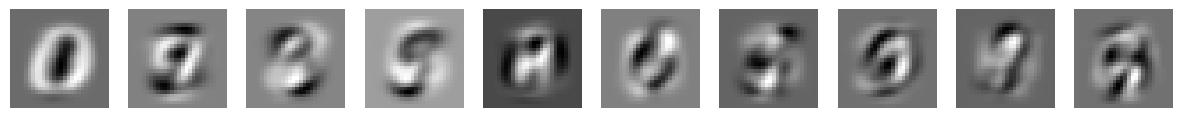

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_mnist()

# Compute the first 10 principal components using x_train

# TO DO
pca = PCA(n_components=10)
pca.fit(x_train)
# print(pca.components_)
display_mnist(pca.components_, subplot_cols=10)
# Display First 10 Components



<Axes: >

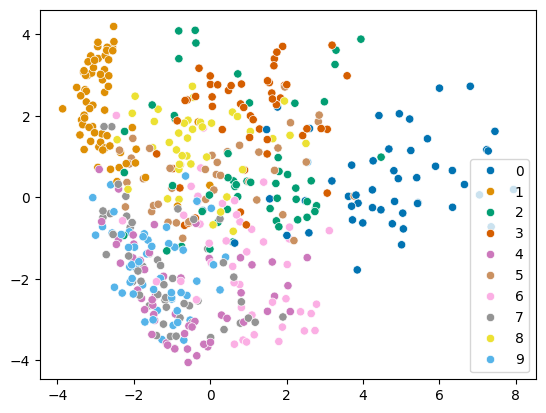

In [53]:
# Scatter plot of first two PCA dimensions
import seaborn as sns

# use pca.transform
# TO DO
pca = PCA(n_components=2)
pca_trans = pca.fit_transform(x_train[:500])
x = pca_trans
# print(x.shape)
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind")

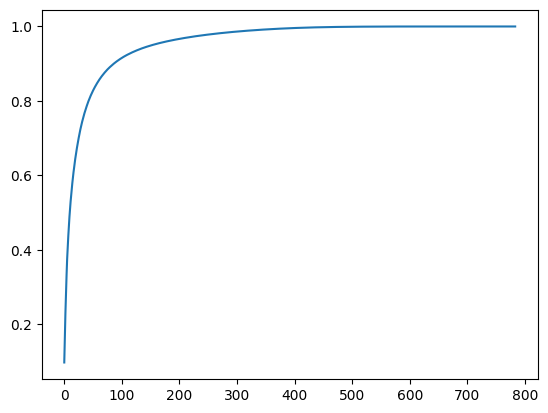

In [54]:
# Plot cumulative explained variance ratio
# cumsum and pca.explained_variance_ratio_ will be useful

# TO DO
pca = PCA()
pca.fit(x_train)
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(cumulative.shape[0]), cumulative)

In [62]:
# Select number of dimensions that explains 90% of variance, according to your plot above
!apt install libomp-dev > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1
import faiss
import time

mask = cumulative<0.9
M = np.sum(mask)
pca = PCA(n_components=M)
pca.fit(x_train)
compress_test = pca.transform(x_test)
compress_train = pca.transform(x_train)

def ONN(x_train, x_test, y_train, y_test):
  begin = time.time()
  right = 0
  index = faiss.IndexFlatL2(x_test.shape[1])  
  index.add(x_train)
  dist, idx = index.search(x_test,1) # returns index and sq err for each sample
  idx = np.array(idx).reshape(idx.shape[0])
  for i in range(len(x_test)):
    if y_test[i] == y_train[idx[i]]:
      right += 1
  acc = right/len(x_test)
  end = time.time()
  timing = end-begin
  return 1-acc, timing




# Get time and error when using original features with brute force 1-NN
# TO DO
error, timing = ONN(x_train, np.concatenate((x_train, x_test), axis=0), y_train, np.concatenate((y_train, y_test), axis=0))
print(f"error rate: {error}, time: {timing}")
# Get time and error when using compressed features with brute force 1-NN
# TO DO
compress_error, compress_timing = ONN(compress_train, np.concatenate((compress_train, compress_test), axis=0), y_train, np.concatenate((y_train, y_test), axis=0))
print(f"error rate: {compress_error}, time: {compress_timing}")



error rate: 0.004414285714285704, time: 8.268681049346924
error rate: 0.0038000000000000256, time: 3.0387001037597656


In [63]:
print(np.concatenate((compress_train, compress_test), axis=0).shape)

(70000, 86)


### Part 2: MNIST Classification with Linear Models

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

LLR/SVM vs training size

In [69]:
# LLR
# TO DO
for N in [100, 1000, 10000, 60000]:
  m = LogisticRegression(max_iter=10000)
  m.fit(x_train[:N], y_train[:N])
  y_pred = m.predict(x_test)
  print(f"N:{N}, error rate: {np.count_nonzero(y_pred!=y_test)/y_pred.shape[0]}")

  

N:100, error rate: 0.325
N:1000, error rate: 0.1364
N:10000, error rate: 0.095
N:60000, error rate: 0.0737


In [73]:
# SVM
# TO DO
for N in [100, 1000, 10000, 60000]:
  m = svm.LinearSVC(max_iter=10000)
  m.fit(x_train[:N], y_train[:N])
  y_pred = m.predict(x_test)
  print(f"N:{N}, error rate: {np.count_nonzero(y_pred!=y_test)/y_pred.shape[0]}")


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


N:100, error rate: 0.3236
N:1000, error rate: 0.1611


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


N:10000, error rate: 0.1112


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


N:60000, error rate: 0.0817


Error visualization

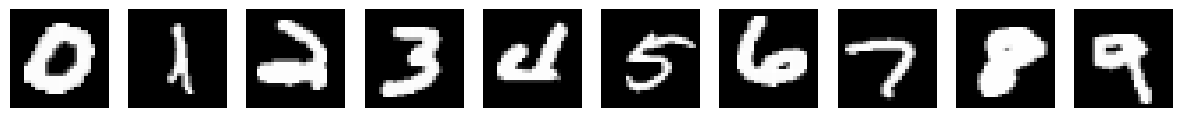

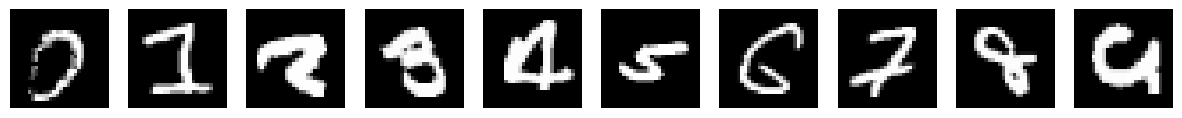

In [89]:
# to get scores for logistic regression use: scores = model_lr.predict_proba(x_test)
# TO DO
import math
m = LogisticRegression(max_iter=10000)
m.fit(x_train, y_train)
scores = m.predict_proba(x_test)
y_pred = m.predict(x_test)
confident = np.zeros((10, x_test.shape[1]))
inconfident = np.zeros((10, x_test.shape[1]))
for i in range(10):
  s = scores[:,i]
  confident[i,:] = x_test[s == np.max(s[(y_pred==i) & (y_pred==y_test)])]
  inconfident[i,:] = x_test[s == np.min(s[(y_test==i) & (y_pred!=y_test)])]
display_mnist(confident, subplot_cols=10)
display_mnist(inconfident, subplot_cols=10)


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


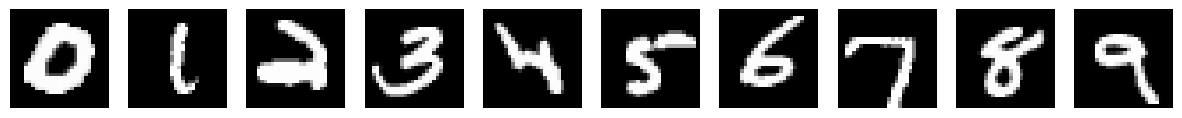

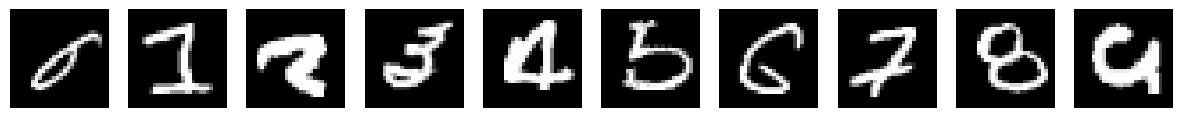

In [91]:

# to get scores for SVM use: scores = model_svm.decision_function(x_test)
# TO DO
m = svm.LinearSVC(max_iter=10000)
m.fit(x_train, y_train)
scores = m.decision_function(x_test)
y_pred = m.predict(x_test)
confident = np.zeros((10, x_test.shape[1]))
inconfident = np.zeros((10, x_test.shape[1]))
for i in range(10):
  s = scores[:,i]
  confident[i,:] = x_test[s == np.max(s[(y_pred==i) & (y_pred==y_test)])]
  inconfident[i,:] = x_test[s == np.min(s[(y_test==i) & (y_pred!=y_test)])]
display_mnist(confident, subplot_cols=10)
display_mnist(inconfident, subplot_cols=10)

Parameter selection

In [99]:
# Try multiple C parameters, select one that minimizes validation error
# Often, you need to try a few values and see those results to determine what other values to try

# TO DO
def find_param(C):
  m = svm.LinearSVC(max_iter=10000, C=C)
  m.fit(x_train[:1000], y_train[:1000])
  y_pred = m.predict(x_train[50000:])
  print(f"C:{C}, error rate: {np.count_nonzero(y_pred!=y_train[50000:])/y_pred.shape[0]}")

for C in [0.25, 0.5, 1, 2, 4]:
  find_param(C)

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:0.25, error rate: 0.1398
C:0.5, error rate: 0.1453


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:1, error rate: 0.1498


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:2, error rate: 0.153


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:4, error rate: 0.1547


In [101]:
for C in [1/8, 1/16, 1/32, 1/64, 1/128]:
  find_param(C)

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:0.125, error rate: 0.1344
C:0.0625, error rate: 0.1287


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:0.03125, error rate: 0.1257
C:0.015625, error rate: 0.1245
C:0.0078125, error rate: 0.1302


In [105]:
for C in [1/32, 1.5/64, 1/64]:
  find_param(C)

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:0.03125, error rate: 0.1257
C:0.0234375, error rate: 0.1246
C:0.015625, error rate: 0.1245


In [106]:
for C in [1.5/64, 1.25/64, 1/64]:
  find_param(C)

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:0.0234375, error rate: 0.1246
C:0.01953125, error rate: 0.1235
C:0.015625, error rate: 0.1245


In [107]:
for C in [1.25/64, 1.125/64, 1/64]:
  find_param(C)

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:0.01953125, error rate: 0.1235
C:0.017578125, error rate: 0.1243
C:0.015625, error rate: 0.1245


In [108]:
for C in [1.25/64, 1.1875/64, 1.125/64]:
  find_param(C)

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


C:0.01953125, error rate: 0.1235
C:0.0185546875, error rate: 0.1239
C:0.017578125, error rate: 0.1243


In [109]:
# Get test result for selected parameter

# TO DO
C = 1.1875/64
m = svm.LinearSVC(max_iter=10000, C=C)
m.fit(x_train[:1000], y_train[:1000])
y_pred = m.predict(x_test)
print(f"C:{C}, error rate: {np.count_nonzero(y_pred!=y_test)/y_pred.shape[0]}")


C:0.0185546875, error rate: 0.1362


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
 

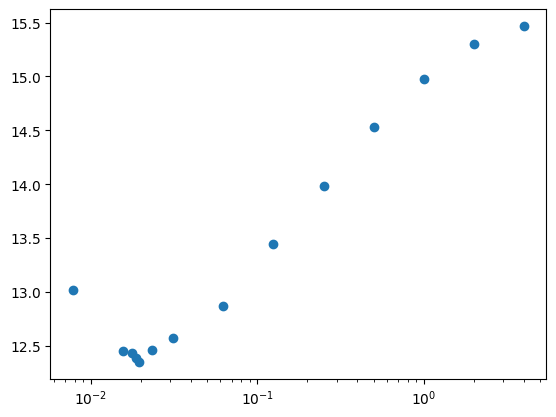

In [129]:
(x_train, y_train), (x_test, y_test) = load_mnist()
# plot 
C_list = [1.25/64, 1.1875/64, 1.125/64, 1/32, 1.5/64, 1/64, 1/8, 1/16, 1/128, 0.25, 0.5, 1, 2, 4]
plot_list = []
for C in C_list:
  m = svm.LinearSVC(max_iter=10000, C=C)
  m.fit(x_train[:1000], y_train[:1000])
  y_pred = m.predict(x_train[50000:])
  plot_list.append(np.count_nonzero(y_pred!=y_train[50000:])/y_pred.shape[0]*100)
plt.semilogx(C_list, plot_list, 'o', label='validation error rate')

## Part 3: Temperature Regression


In [130]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  datadir = "./"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


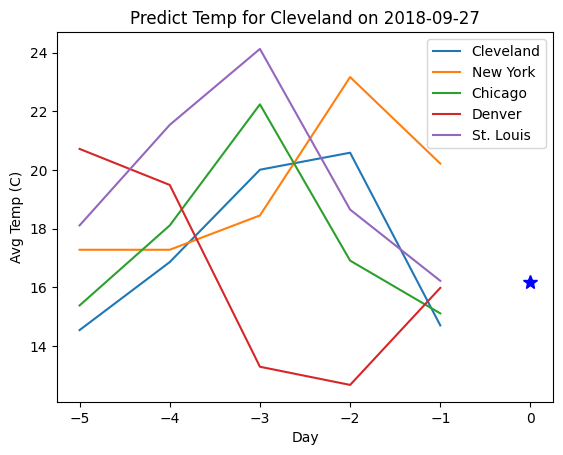

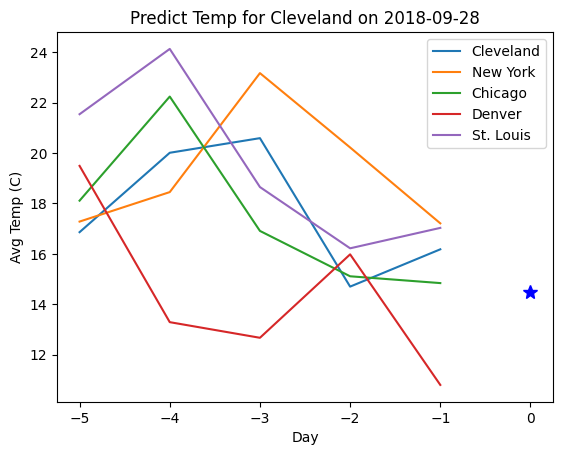

In [131]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[1], y_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



Linear regression test

In [132]:
def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i,fnum]
  return x2, y2

In [133]:
 # linear regression (use Ridge)
from sklearn.linear_model import Ridge
ridge = Ridge()
# original features
# TO DO
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print(f"original rmse: {np.sqrt(np.mean((y_test-y_pred)**2))}")
# normalized features
# TO DO
x_train_new, y_train_new = normalize_features(x_train, y_train, 361)
x_test_new, y_test_new = normalize_features(x_test, y_test, 361)
ridge = Ridge()
ridge.fit(x_train_new, y_train_new)
y_predict_new = ridge.predict(x_test_new)
print(f"normalized rmse: {np.sqrt(np.mean((y_test_new-y_predict_new)**2))}")

original rmse: 2.1608605260810148
normalized rmse: 2.163069802757245


Feature selection

In [165]:
# feature analysis (select important features using Lasso)
# TO DO
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(x_train, y_train)
top_cords = np.array(list(range(lasso.coef_.shape[0])))[abs(lasso.coef_)>0.001]
d = {}
for i in top_cords:
  d[abs(lasso.coef_[i])] = i
d_value = sorted(d, reverse=True)
cords = [d[i] for i in d_value][:10]
for i in cords:
  print(f"index: {i}, day: {feature_to_day[i]}, city: {feature_to_city[i]}")


index: 334, day: -1, city: Chicago
index: 347, day: -1, city: Minneapolis
index: 405, day: -1, city: Grand Rapids
index: 366, day: -1, city: Kansas City
index: 361, day: -1, city: Cleveland
index: 307, day: -2, city: Omaha
index: 367, day: -1, city: Indianapolis
index: 264, day: -2, city: Minneapolis
index: 9, day: -5, city: Boston
index: 236, day: -3, city: Springfield


In [168]:
# predict using best features
# TO DO
select_x_train = x_train[:, cords]
# print(select_x_train.shape)
select_x_test = x_test[:, cords]
ridge = Ridge()
ridge.fit(select_x_train, y_train)
y_pred = ridge.predict(select_x_test)
print(f"rmse: {np.sqrt(np.mean((y_test-y_pred)**2))}")

rmse: 2.062133827192541


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

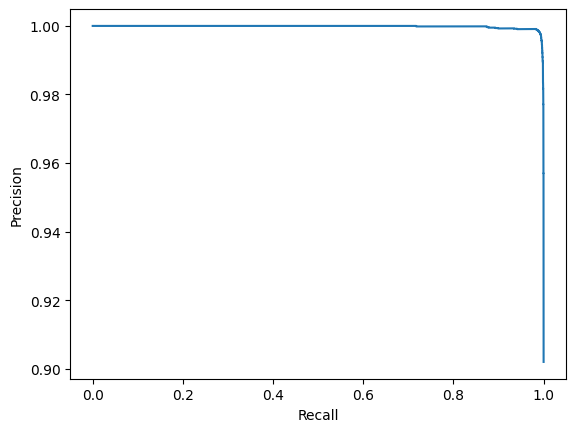

In [181]:
# TO DO (optional)
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
(x_train, y_train), (x_test, y_test) = load_mnist()
m = LogisticRegression(max_iter=10000)
y_train = y_train!=0
y_test = y_test!=0
m.fit(x_train, y_train)
y_prob = m.predict_proba(x_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.step(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [182]:
print(f"ap: {average_precision_score(y_test, y_prob)}")

ap: 0.9998083495632465


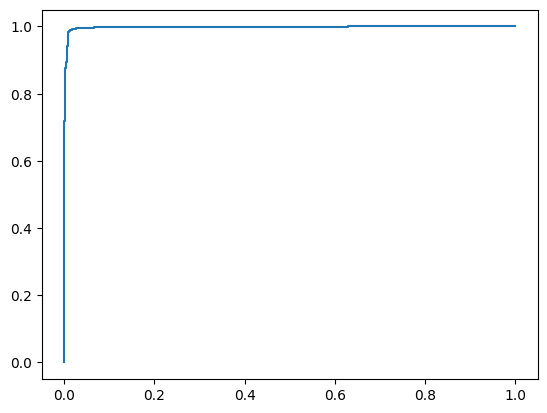

AUC: 0.9983122539481424


In [187]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.show()
AUC = auc(fpr, tpr)
print(f"AUC: {AUC}")

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


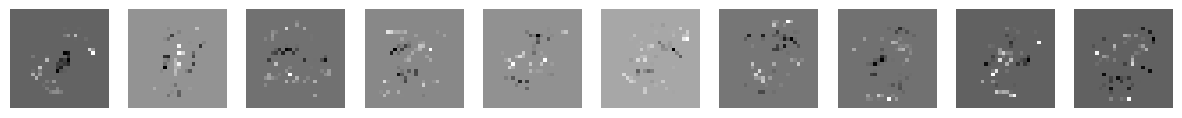

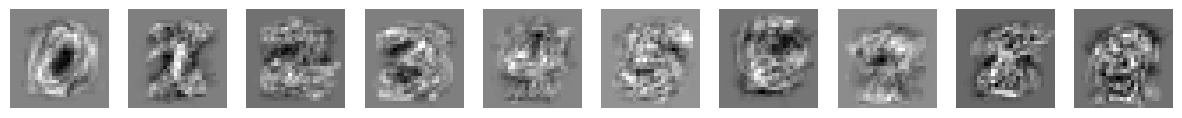

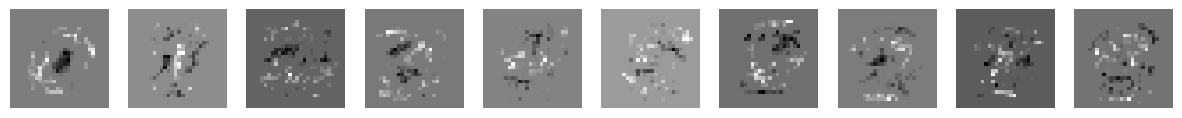

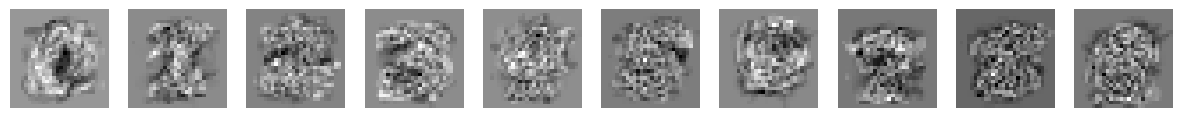

In [190]:
(x_train, y_train), (x_test, y_test) = load_mnist()
X = x_train[:1000]
Y = y_train[:1000]

l1_model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
l1_model.fit(X, Y)
display_mnist(l1_model.coef_, subplot_cols=10)

l2_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
l2_model.fit(X, Y)
display_mnist(l2_model.coef_, subplot_cols=10)

elastic_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
elastic_model.fit(X, Y)
display_mnist(elastic_model.coef_, subplot_cols=10)

svm_model = svm.LinearSVC(loss='squared_hinge', penalty='l2', dual=False, max_iter=1000)
svm_model.fit(X, Y)
display_mnist(svm_model.coef_, subplot_cols=10)

<Axes: >

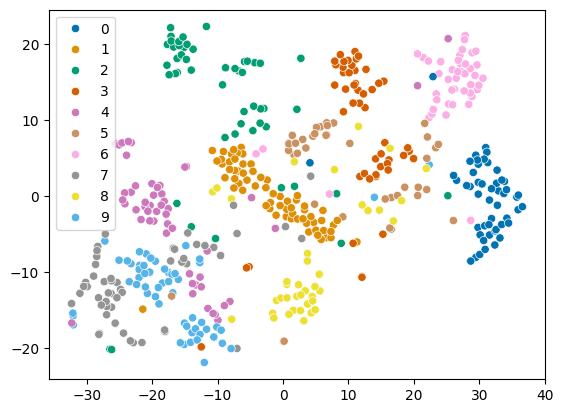

In [192]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_trans = tsne.fit_transform(x_train[:500])
x = tsne_trans
# print(x.shape)
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind")

<Axes: >

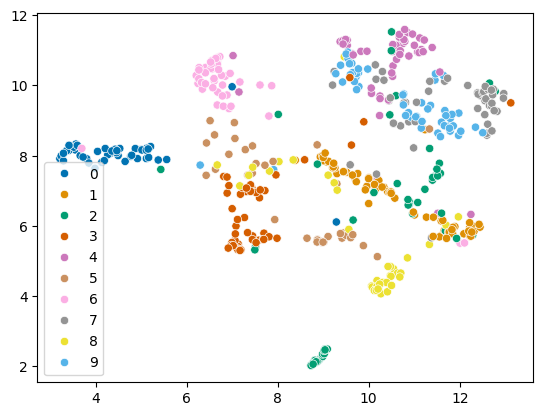

In [194]:
from umap import UMAP
umap = UMAP(n_components=2)
umap_trans = umap.fit_transform(x_train[:500])
x = umap_trans
# print(x.shape)
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind")

In [204]:
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
cities = np.unique(feature_to_city)
rmse = []
for city in cities:
  train, test, val = x_train[:,feature_to_city==city], x_test[:,feature_to_city==city], x_val[:,feature_to_city==city]
  ridge = Ridge()
  ridge.fit(train, y_train)
  y_pred = ridge.predict(val)
  rmse.append(np.sqrt(np.mean((y_val-y_pred)**2)))
print(cities[rmse==np.min(rmse)])

['St. Louis']


In [205]:
train, test, val = x_train[:,feature_to_city=='St. Louis'], x_test[:,feature_to_city=='St. Louis'], x_val[:,feature_to_city=='St. Louis']
ridge = Ridge()
ridge.fit(train, y_train)
y_pred = ridge.predict(test)
print(np.sqrt(np.mean((y_test-y_pred)**2)))

3.1263272970544818


In [206]:
(x_train, y_train), (x_test, y_test) = load_mnist()
for N in [100, 1000, 10000, 60000]:
  m = svm.LinearSVC(max_iter=10000)
  m.fit(x_train[:N], y_train[:N])
  y_pred = m.predict(x_test)
  print(f"N:{N}, error rate: {np.count_nonzero(y_pred!=y_test)/y_pred.shape[0]}")

/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


N:100, error rate: 0.3236
N:1000, error rate: 0.1611


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


N:10000, error rate: 0.1112


/Users/janghl/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


N:60000, error rate: 0.0817


In [207]:
(x_train, y_train), (x_test, y_test) = load_mnist()
for N in [100, 1000, 10000, 60000]:
  m = svm.SVC(max_iter=10000)
  m.fit(x_train[:N], y_train[:N])
  y_pred = m.predict(x_test)
  print(f"N:{N}, error rate: {np.count_nonzero(y_pred!=y_test)/y_pred.shape[0]}")

N:100, error rate: 0.3441
N:1000, error rate: 0.0917
N:10000, error rate: 0.0406
N:60000, error rate: 0.0208
